# Moving Box - Generalize for Boxes with Large Gap

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Collect an ensemble of box data

imgs shape:     (56, 32, 32)
info:           {'dim': (56, 32, 32), 'images:': 'square-vertical'}


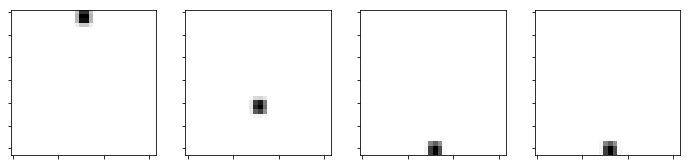

In [9]:
img_collections = get_processed_moving_box()
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

### Proprocess: [0, 1] -> [-1, 1]

In [10]:
def preprocess(imgs):
    return 2*imgs-1

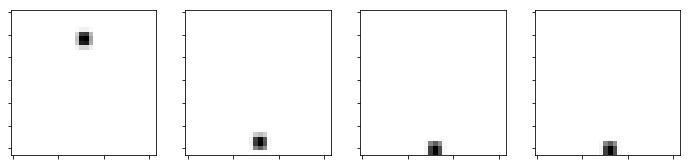

In [11]:
imgs = preprocess(imgs)
sample_and_show_many(imgs, 4)

#### Sample Data from Training Corpus

In [86]:
gap = 9
batch_size = 8
def sample_real():
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

#### test sample_real

Before: (8, 32, 32)
After:  (8, 32, 32)
Mid:    (8, 32, 32)


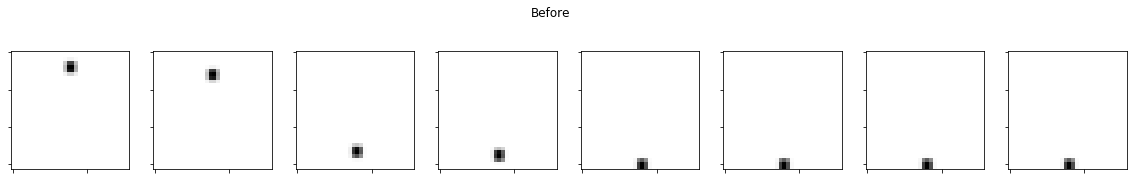

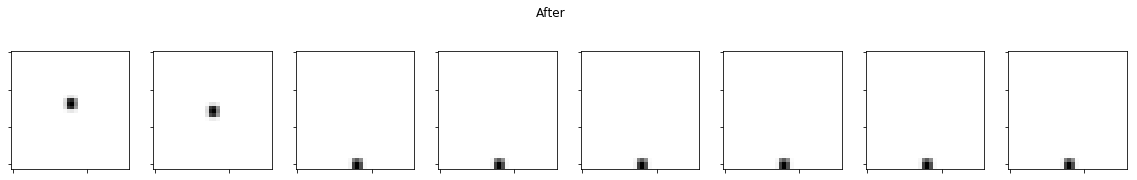

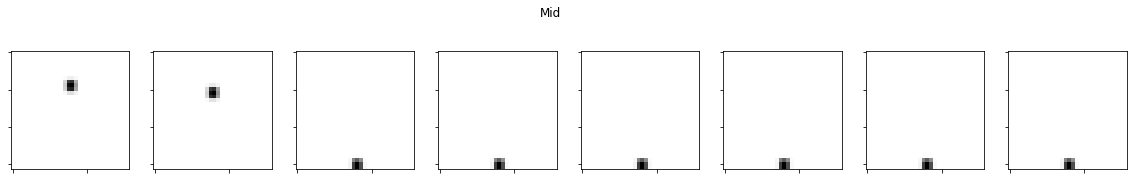

In [87]:
(test_before, test_after), test_mid = sample_real()
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (20, 3)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid")

#### test stack

In [88]:
stacked = stack_imgs([test_before, test_after])
print("Stacked: {}".format(stacked.shape))

Stacked: (8, 32, 32, 2)


## Param

In [89]:
learning_rate = 4e-4
beta = 0.5
num_epoch = 400
noise_dim = 128

## Loss

In [90]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)/batch_size

In [91]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Generator

In [92]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator"):
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)/2], axis=3)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

In [93]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [94]:
def train(sess, G_step, G_loss, batch_size, num_eposh, plot_every = 200, show_loss_every=200):
    max_iter = int(num_train*num_epoch/batch_size)
    g_losses = []
    for i in range(max_iter):
        (real_before, real_after), real_mid = sample_real()
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            g_losses.append(G_loss_curr)
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict={batch_before: test_before, batch_after: test_after, is_training: False})
            plot_batch_images(gen_batch_test, (16, 2) , "Iteration: {}".format(i))
    return g_losses

Iteration 0:  G_loss = 12.5780029296875


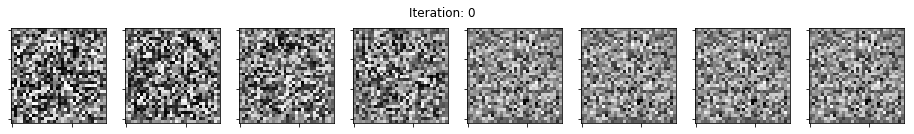

Iteration 200:  G_loss = 1.5139211416244507


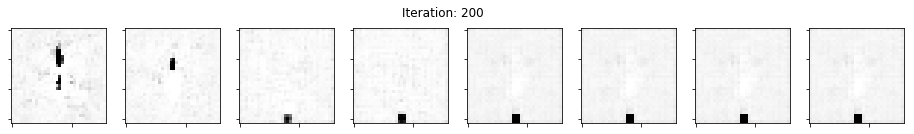

Iteration 400:  G_loss = 0.736691951751709


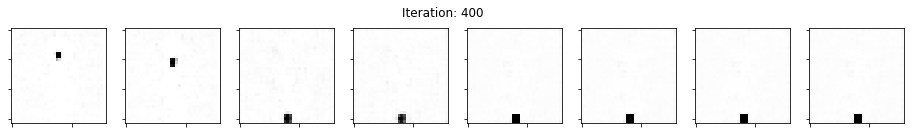

Iteration 600:  G_loss = 0.6058605909347534


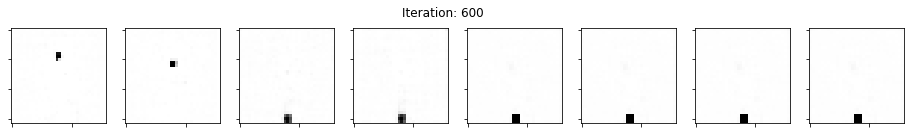

Iteration 800:  G_loss = 0.5580936670303345


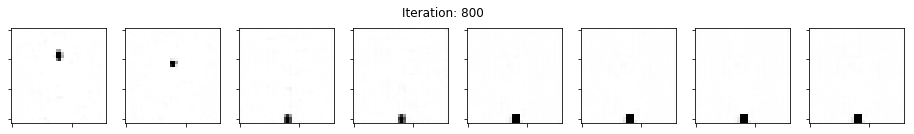

Iteration 1000:  G_loss = 0.4587754011154175


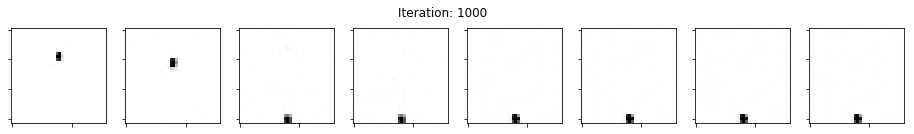

Iteration 1200:  G_loss = 0.3917814791202545


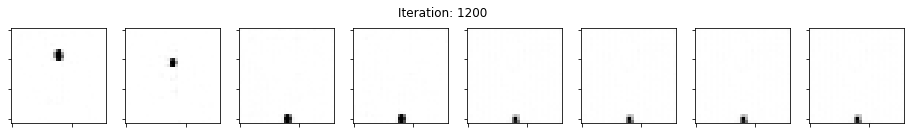

Iteration 1400:  G_loss = 0.29160448908805847


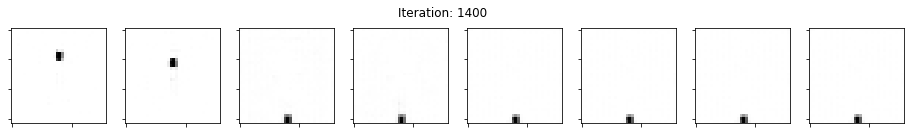

Iteration 1600:  G_loss = 0.22896094620227814


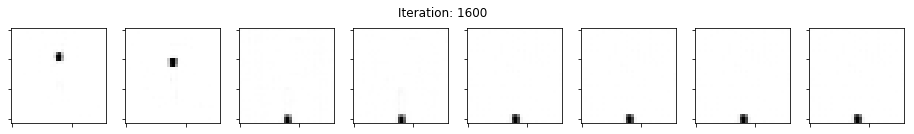

Iteration 1800:  G_loss = 0.18089976906776428


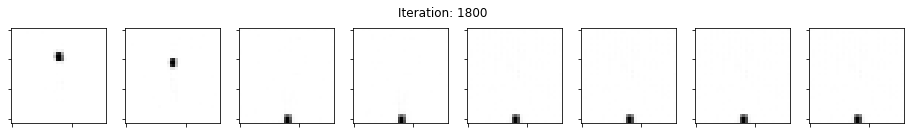

Iteration 2000:  G_loss = 0.2081509530544281


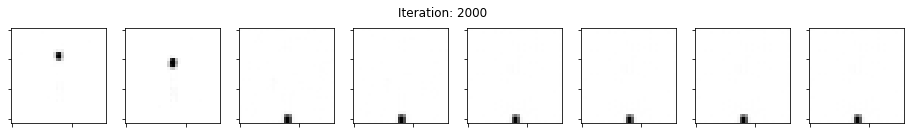

Iteration 2200:  G_loss = 0.13332748413085938


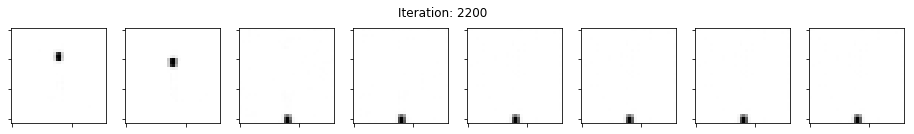

Iteration 2400:  G_loss = 0.18616436421871185


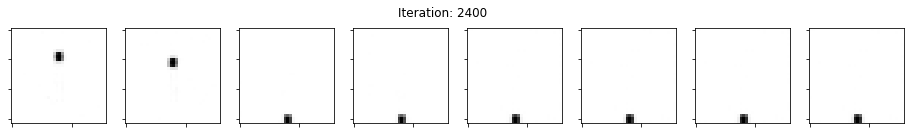

Iteration 2600:  G_loss = 0.16273127496242523


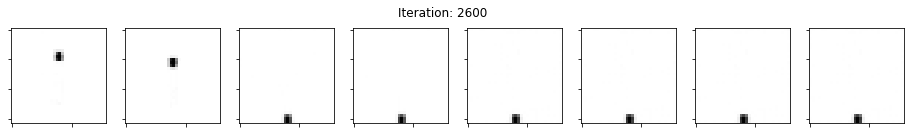

In [95]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_epoch)

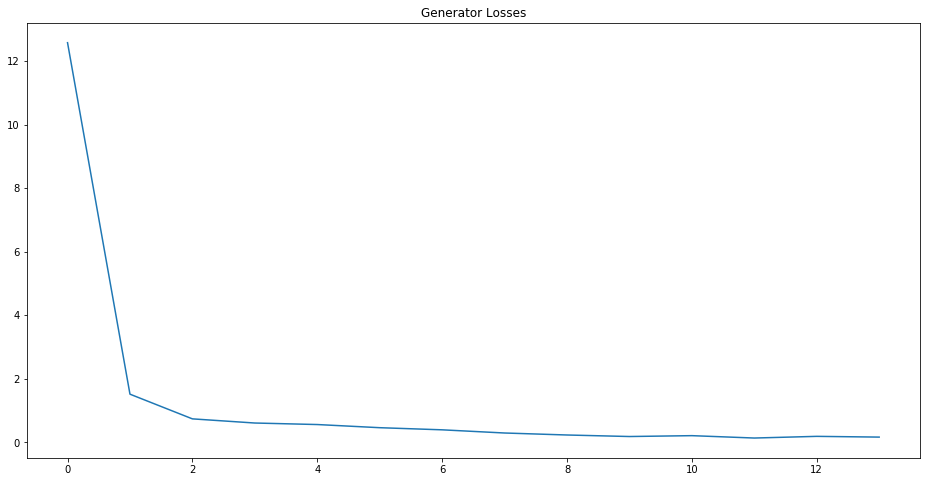

In [96]:
figsize = (16, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

## Evaluate on Training Data

In [97]:
def test():
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_real()
    dic = {batch_before: real_before, batch_after: real_after, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    size = (12, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

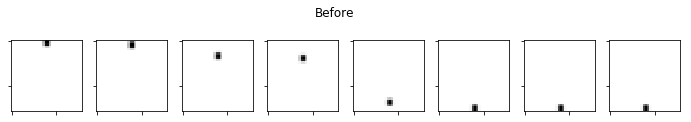

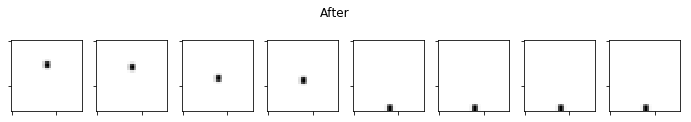

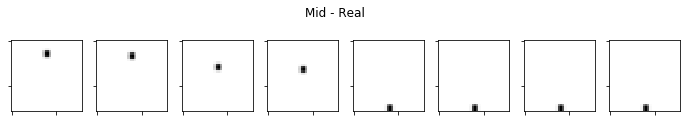

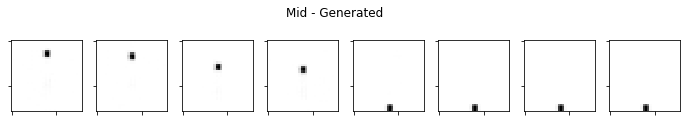

In [98]:
test()

In [103]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    return gen_batch, 255 * loss

In [104]:
num_test = 1000
loss = np.mean([get_generattion(test_before, test_after, test_mid)[1] for _ in range(num_test)])
print("Training Loss = {}".format(loss))

Training Loss = 23.688923922032117
